In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

# Chapter 10 - Memory retention
  
This Chapter is about estimating the relationship between memory retention and time.
The model being considered is a simplified version of the exponential decay model. The model assumes that the probability that an item will be remembered after a period of time $t$ has elapsed is $\theta_{t} = \text{exp}(−\alpha t)+\beta$, with the restriction $0 < \theta_{t} < 1$. The $\alpha$ parameter corresponds to the rate of decay of information. The $\beta$ parameter corresponds to a baseline level of remembering that is assumed to remain even after very long time periods.
  
## 10.1 No individual differences


$$ \alpha \sim \text{Beta}(1,1)$$
$$ \beta \sim \text{Beta}(1,1)$$
$$ \theta_{j} = \text{min}(1,\text{exp}(−\alpha t_{j})+\beta)$$
$$ k_{ij} \sim \text{Binomial}(\theta_{j},n)$$

Assigned Metropolis to kij_missing
100%|██████████| 3000/3000.0 [00:21<00:00, 141.28it/s]


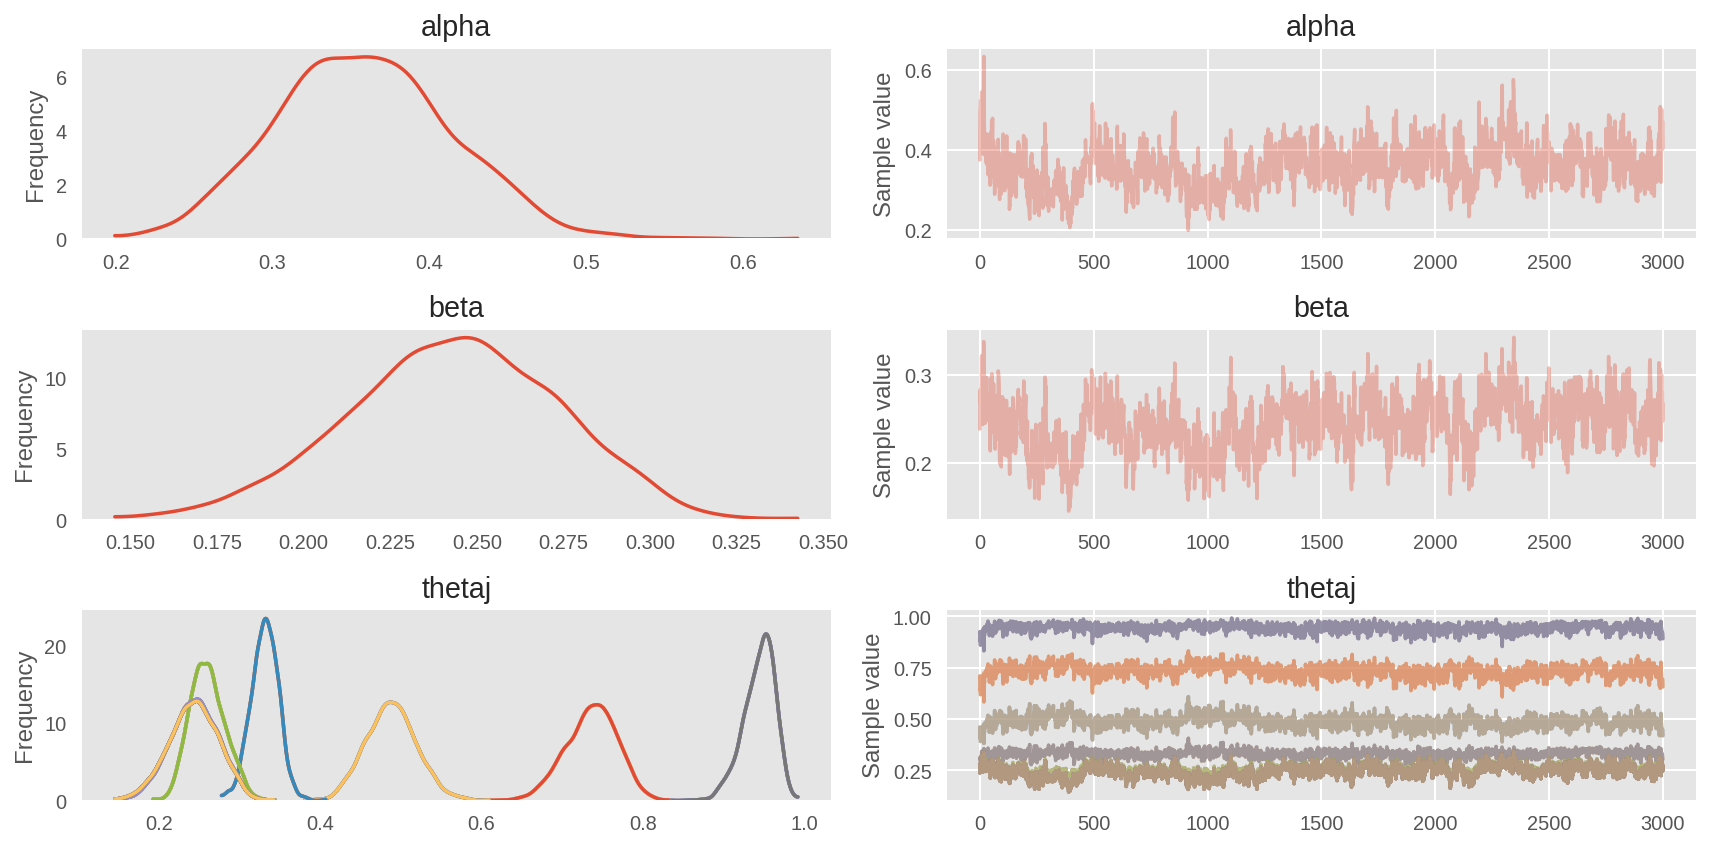

In [2]:
t     = np.array([1, 2, 4, 7, 12, 21, 35, 59, 99, 200])
nt    = len(t)
# slist = [0,1,2,3]
ns    = 4
tmat  = np.repeat(t,ns).reshape(nt,-1).T
k1 = np.ma.masked_values([18, 18, 16, 13, 9, 6, 4, 4, 4, -999,
                          17, 13,  9,  6, 4, 4, 4, 4, 4, -999,
                          14, 10,  6,  4, 4, 4, 4, 4, 4, -999,
                          -999, -999, -999, -999, -999, -999, -999, -999, -999, -999], 
                          value=-999).reshape(ns,-1)
n = 18

with pm.Model() as model1:
    # prior
    alpha = pm.Beta('alpha', alpha=1, beta=1, testval=.30)
    beta = pm.Beta('beta', alpha=1, beta=1, testval=.25)
    
    # parameter transformation
    theta = tt.exp(-alpha*tmat)+beta
    #thetaj = pm.Deterministic('thetaj', tt.clip(theta, 0, 1))
    thetaj = pm.Deterministic('thetaj', tt.minimum(theta, 1))
    
    kij = pm.Binomial('kij', p=thetaj, n=n, observed=k1)
    
    step = pm.NUTS(target_accept=.99)
    trace1 = pm.sample(3e3, step=step, init=None, tune=1000)

pm.traceplot(trace1, varnames=['alpha', 'beta', 'thetaj']);
plt.show()

The above model is very sensitivity to the starting value. We can specified a starting value for each parameter by assigning a `testval` when the RV is created:
```python
alpha = pm.Beta('alpha', alpha=1, beta=1, testval=.35)
```

In fact, with a bad starting value, the trace of the above model is stationary. (Tested on PyMC3 v3.1.rc2, it might improve with the future release.)

Alternatively, we can model the non-masked data, in this case the ADVI initialization will work nicely.

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
  0%|          | 0/200000 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
Average ELBO = -71.652: 100%|██████████| 200000/200000 [00:11<00:00, 17004.40it/s]
Finished [100%]: Average ELBO = -71.628
100%|██████████| 3000/3000.0 [00:03<00:00, 781.20it/s]


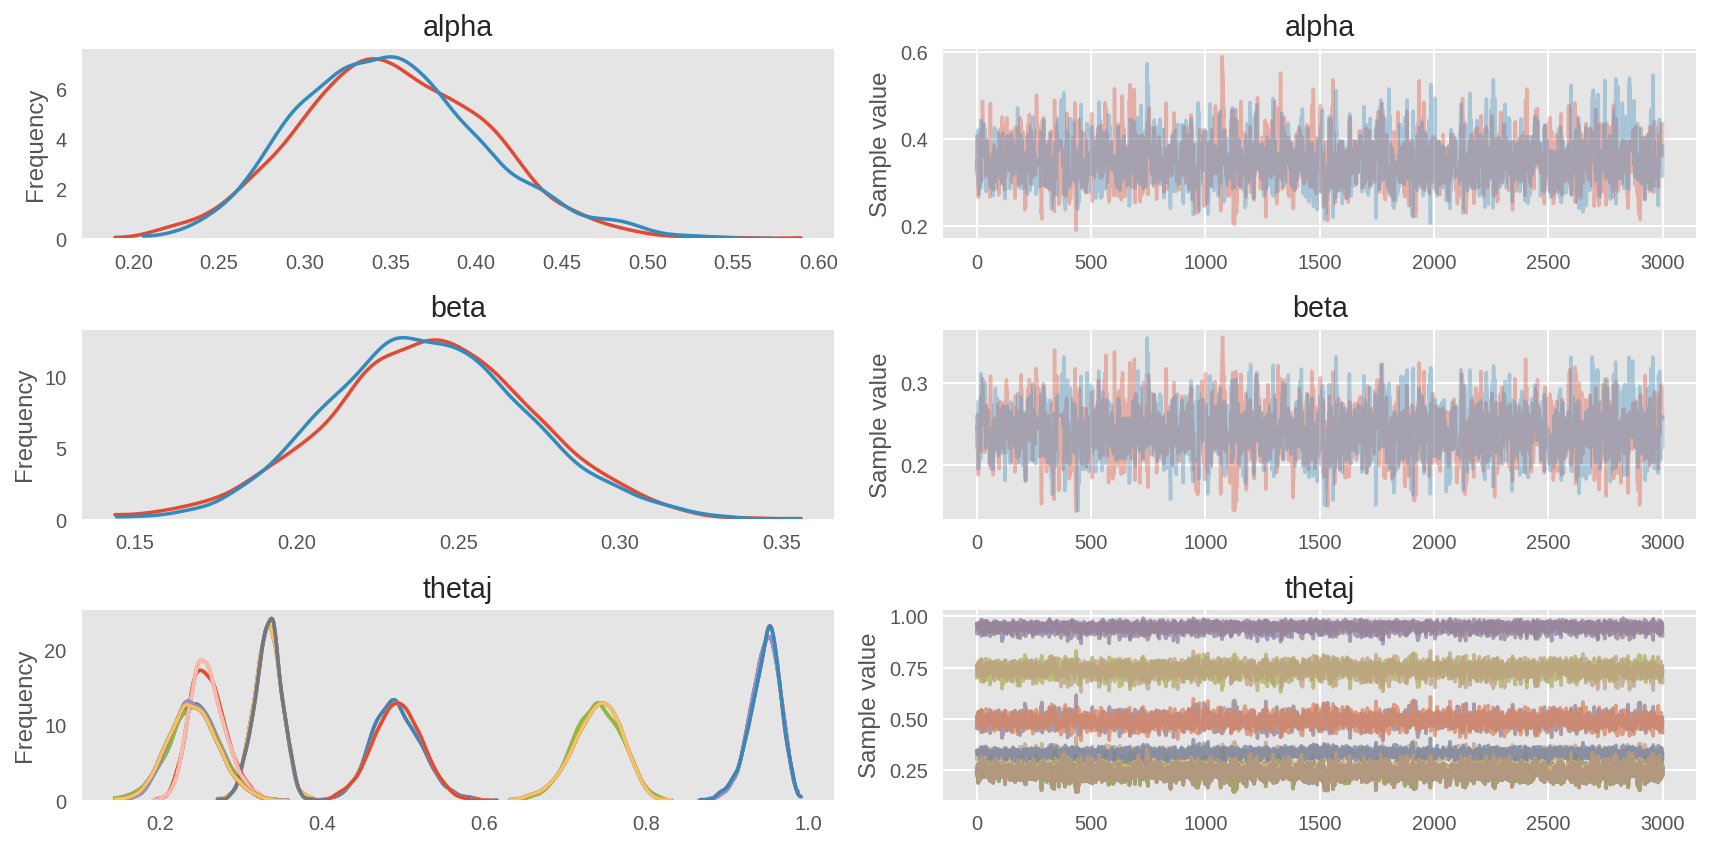

In [3]:
t2     = np.array([1, 2, 4, 7, 12, 21, 35, 59, 99])
nt2    = len(t2)
# slist = [0,1,2,3]
ns2    = 3
tmat2  = np.repeat(t2,ns2).reshape(nt2,-1).T
k2 = np.asarray([18, 18, 16, 13, 9, 6, 4, 4, 4, 
                 17, 13,  9,  6, 4, 4, 4, 4, 4, 
                 14, 10,  6,  4, 4, 4, 4, 4, 4]).reshape(ns2,-1)

with pm.Model() as model1_:
    # prior
    alpha = pm.Beta('alpha', alpha=1, beta=1)
    beta = pm.Beta('beta', alpha=1, beta=1)
    
    # parameter transformation
    theta = tt.exp(-alpha*tmat2)+beta
    thetaj = pm.Deterministic('thetaj', tt.clip(theta, 0, 1))
    
    kij = pm.Binomial('kij', p=thetaj, n=n, observed=k2)
    
    trace1_ = pm.sample(3e3, tune=1000, njobs=2)

pm.traceplot(trace1_, varnames=['alpha', 'beta', 'thetaj']);
plt.show()

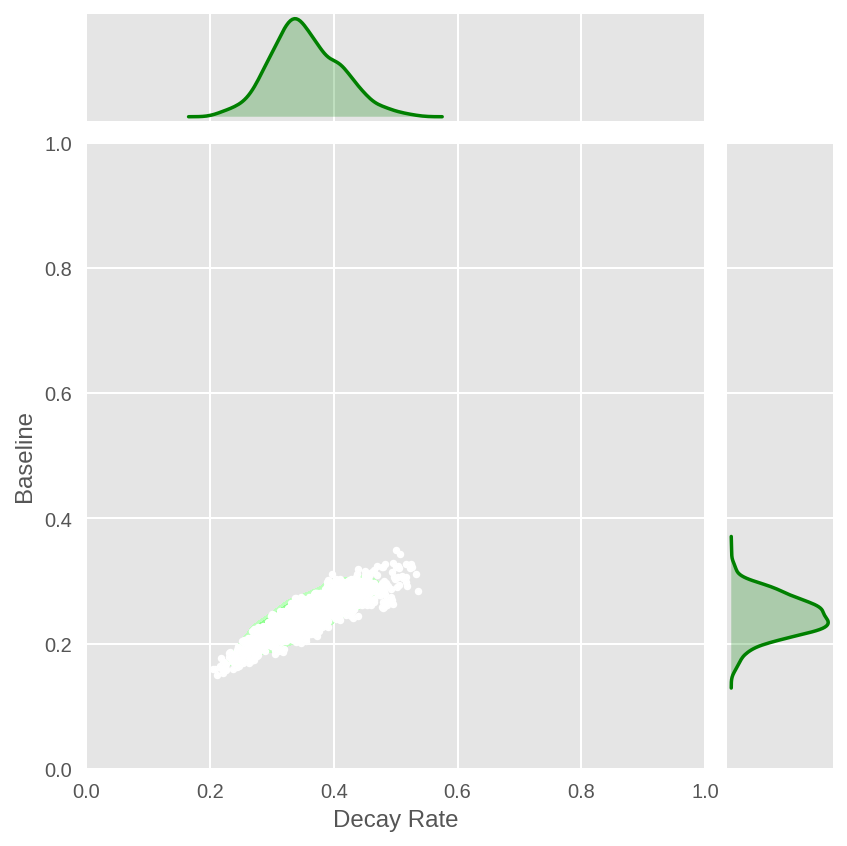

In [4]:
# reproduce Fig 10.2
burnin = 1000

xtrace = trace1['alpha'][burnin:]
ytrace = trace1['beta'][burnin:]

datmp2 = np.vstack((xtrace, ytrace))

df2 = pd.DataFrame(datmp2.transpose(), columns=["x", "y"])

g = sns.jointplot(x="x", y="y", data=df2, kind="kde", color="g", 
                  stat_func=None ,xlim=(0,1), ylim=(0,1))
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker=".",)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels('Decay Rate', 'Baseline')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

100%|██████████| 500/500 [00:07<00:00, 68.65it/s]


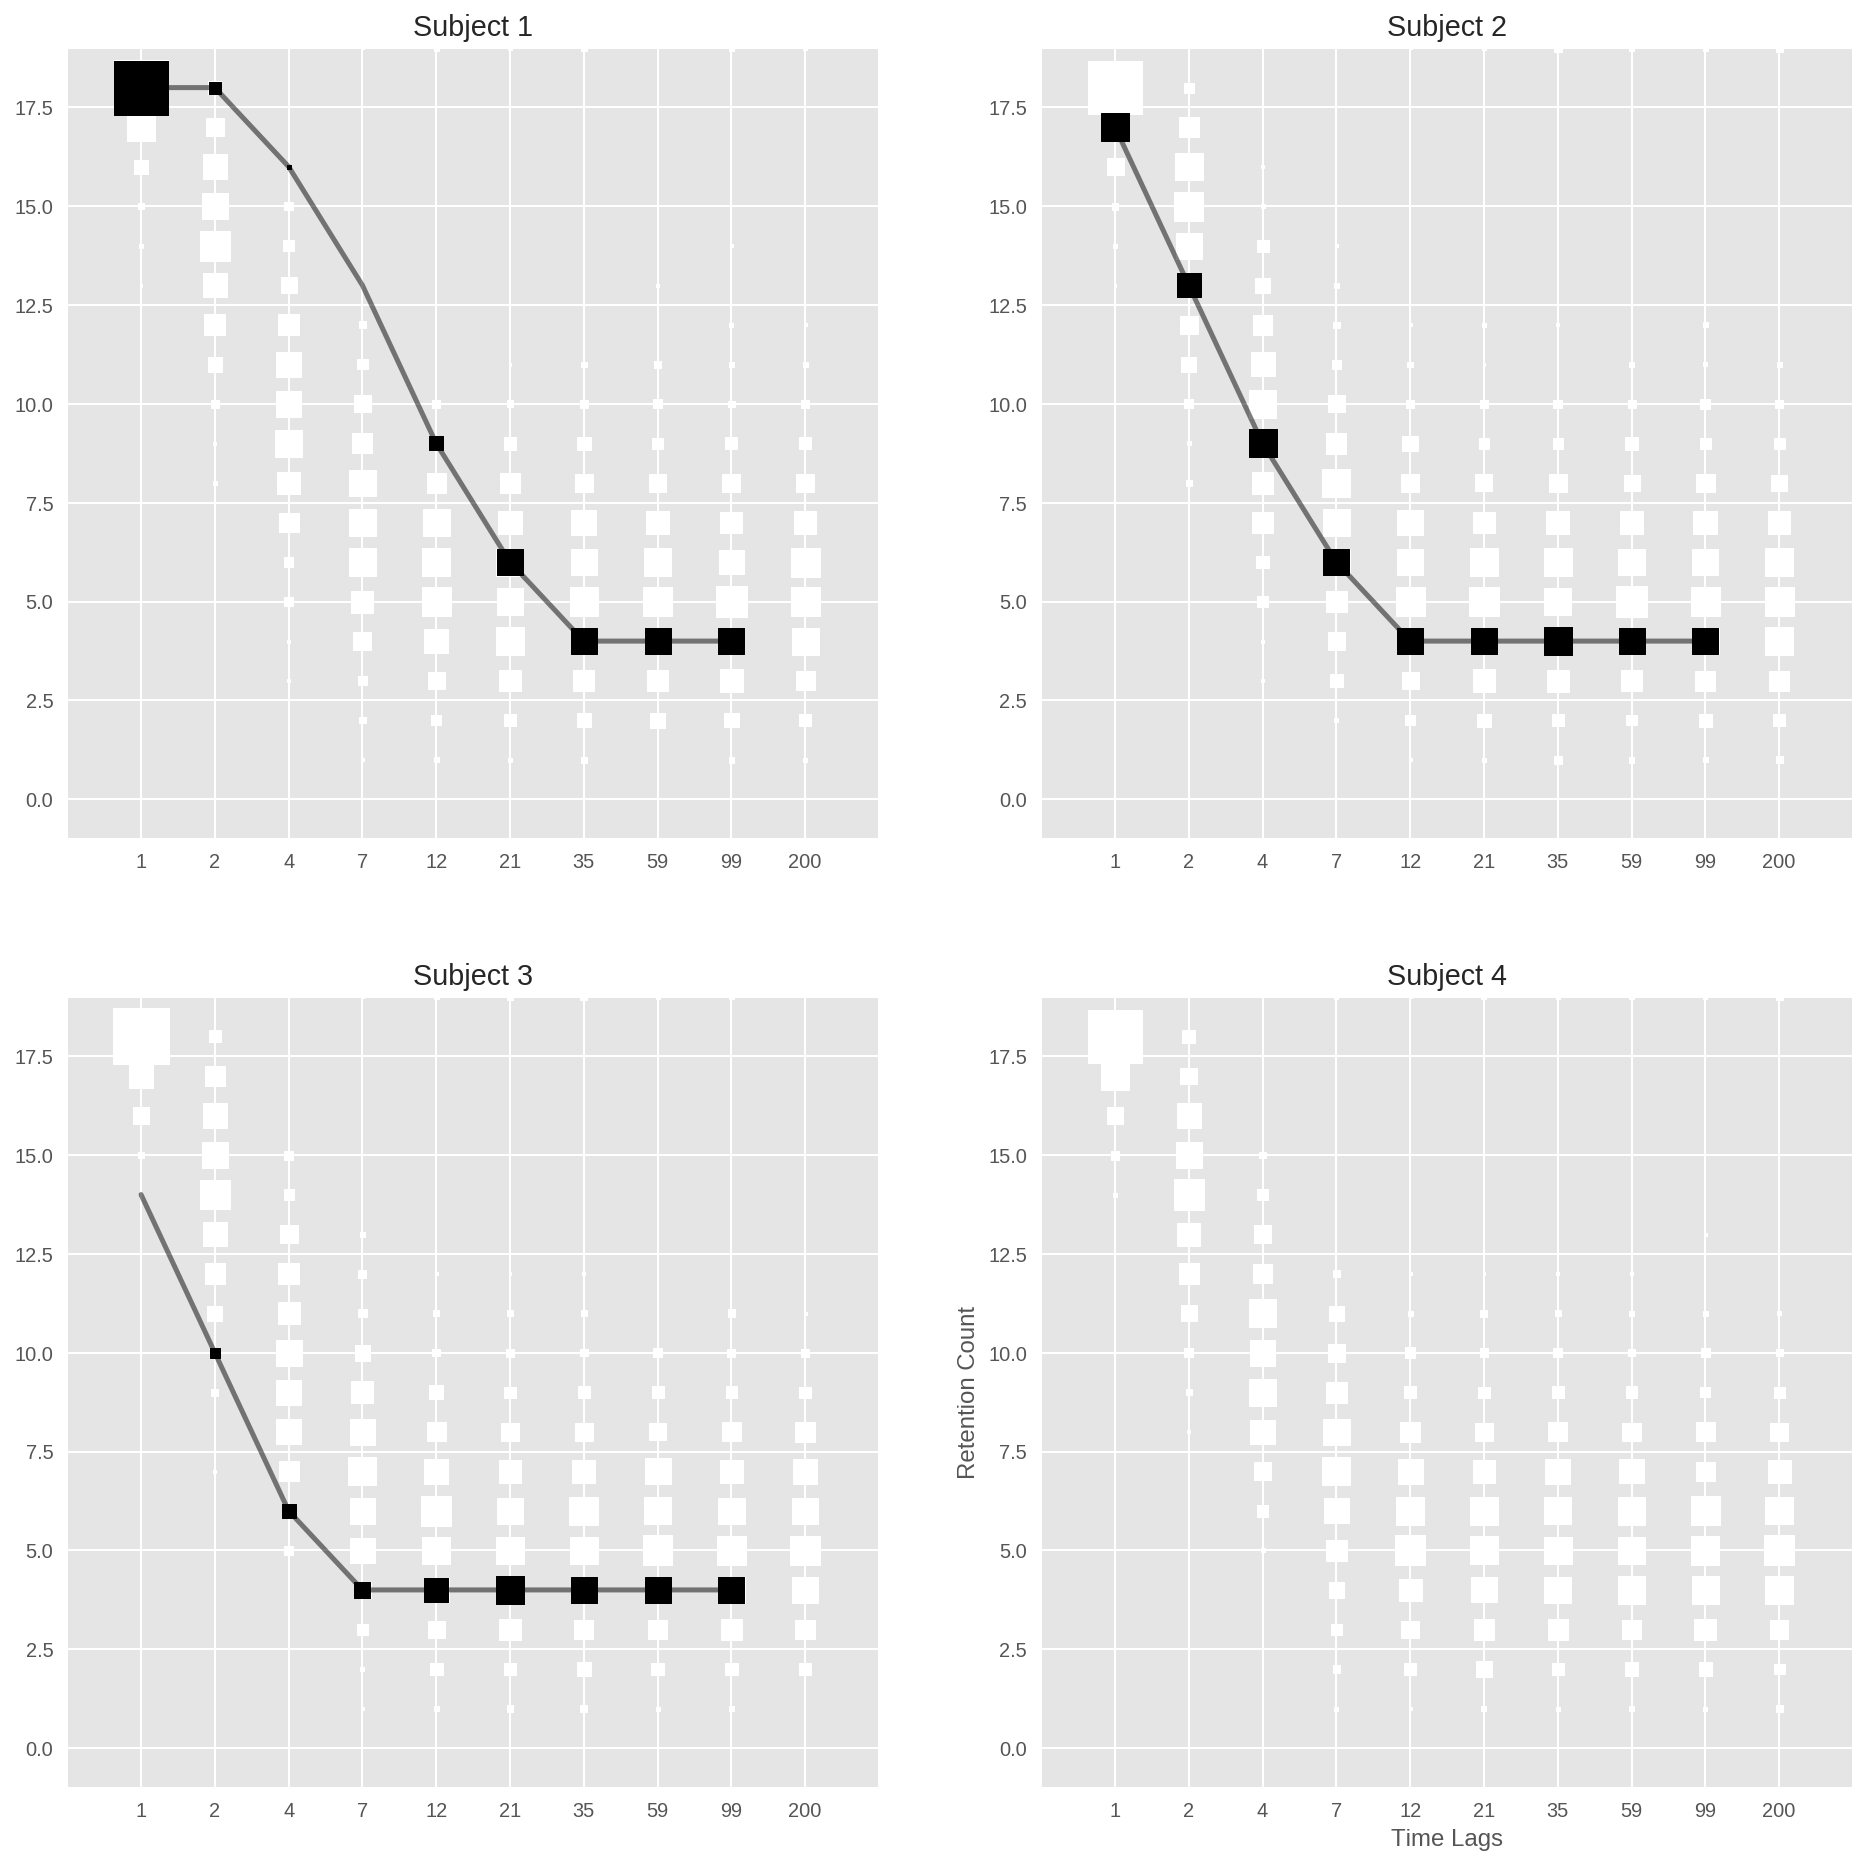

In [13]:
# reproduce Fig 10.3
# The posterior predictive distribution for the model that assumes no individual
# differences.
ppc = pm.sample_ppc(trace1[burnin:], model=model1, samples=500)
predictrace = ppc['kij']
def plot_predict(predictrace):
    ns_, t_ = predictrace.shape[1:]
    plt.figure(figsize=(16, 16))
    gs = gridspec.GridSpec(2, 2)
    bins = np.arange(0, n+1)
    ax1=[];
    for ip in np.arange(ns_):
        ispredi = np.squeeze(predictrace[:, ip, :])
        ax1 = plt.subplot(gs[ip])
        for itt in np.arange(t_):
            y2, binEdges2 = np.histogram(ispredi[:, itt], bins=bins, normed=True)
            ax1.scatter(itt*np.ones(bins.size), binEdges2+1, s=y2*1000, c='w', marker='s')
            if (k1[ip,itt] is np.ma.masked)==0:
                ax1.scatter(itt, k1[ip,itt], s=y2[k1[ip,itt]-1]*1000, c='k', marker='s')
        plt.plot(np.arange(len(t)), k1[ip, :], 'k', lw=2.5, alpha=.5)
        plt.xlim(-1,10)
        plt.ylim(-1,19)
        plt.xticks(np.arange(len(t)), t)
        plt.title('Subject %s'%(ip+1))
    plt.xlabel('Time Lags')
    plt.ylabel('Retention Count')
    plt.show()
    
plot_predict(predictrace)

## 10.2 Full individual differences


$$ \alpha_{i} \sim \text{Beta}(1,1)$$
$$ \beta_{i} \sim \text{Beta}(1,1)$$
$$ \theta_{ij} = \text{min}(1,\text{exp}(−\alpha_{i} t_{j})+\beta_{i})$$
$$ k_{ij} \sim \text{Binomial}(\theta_{ij},n)$$

In [20]:
import theano
tshare = theano.shared(t2)
cshare = theano.shared(np.ones(t2.shape))

with pm.Model() as model2_:
    alpha = pm.Beta('alpha', alpha=1, beta=1, 
                    shape=ns2, testval=np.asarray([.3, .3, .3]))
    beta = pm.Beta('beta', alpha=1, beta=1, 
                   shape=ns2, testval=np.asarray([.25, .25, .25]))
    
    theta = tt.exp(-tt.outer(alpha, tshare)) + tt.outer(beta, cshare)
    thetaj = pm.Deterministic('thetaj', tt.minimum(theta, 1))
    
    kij = pm.Binomial('kij', p=thetaj, n=n, observed=k2)
    
#     step = pm.NUTS(target_accept=.99)
#     trace2_ = pm.sample(1e4, tune=1000, init='ADVI_MAP', njobs=2)
    
#     v_params = pm.variational.advi(n=100000)
#     trace2_ = pm.variational.sample_vp(v_params, 3000, progressbar=False,
#                                          hide_transformed=False)
    # New ADVI api
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace2_ = approx.sample_vp(3000) 
    
    elbos1 = -inference.hist

Average Loss = inf: 100%|██████████| 20000/20000 [00:01<00:00, 13189.44it/s]
Finished [100%]: Average Loss = inf
Average Loss = inf: 100%|██████████| 10000/10000 [00:00<00:00, 13248.68it/s]
Finished [100%]: Average Loss = inf


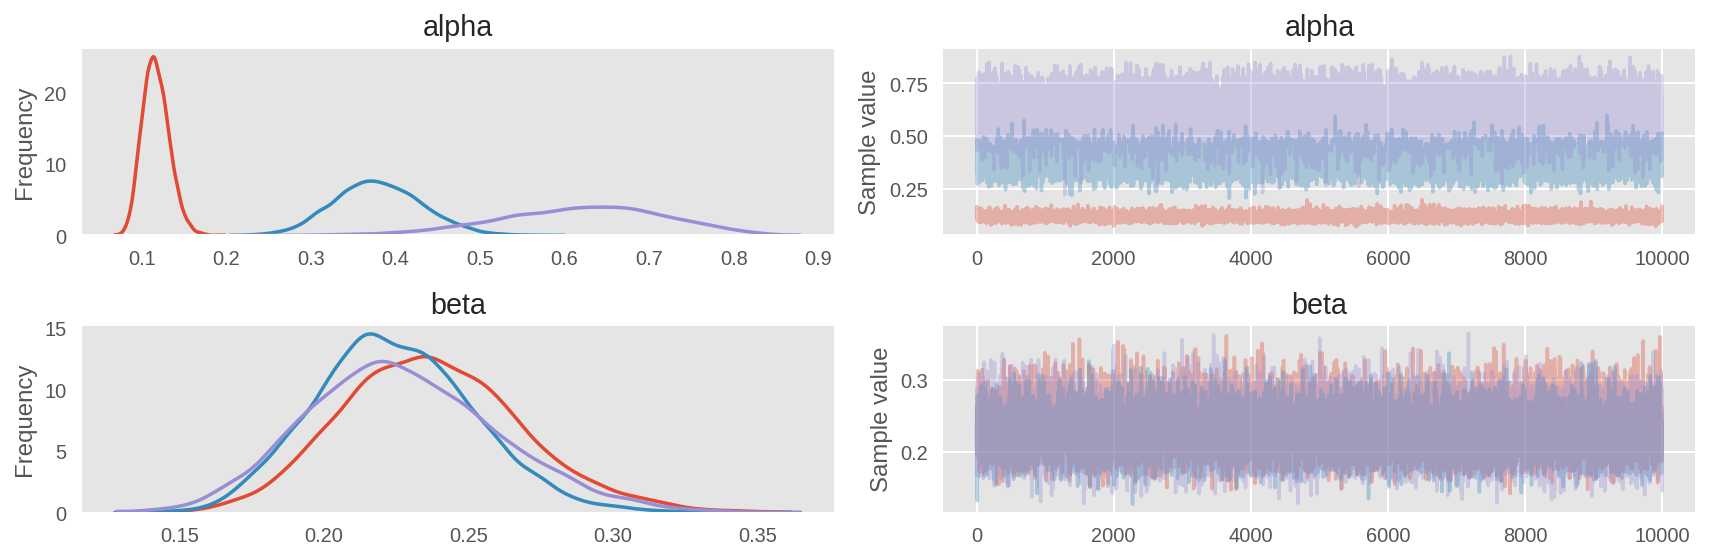

In [21]:
burnin=0
pm.traceplot(trace2_[burnin:], varnames=['alpha', 'beta']);
plt.show()

In [8]:
# reproduce Fig 10.5
def scatter_alpha_beta(trace):
    from matplotlib.ticker import NullFormatter
    nullfmt = NullFormatter()         # no labels
    xtrace = trace['alpha'][1000:]
    ytrace = trace['beta'][1000:]
    ns_ = xtrace.shape[1]

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # now determine limits by hand:
    binwidth1 = 0.25

    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 8))

    cc = np.array([[1., 0., 0.],
                   [0., 1., 0.],
                   [0., 0., 1.],
                   [.5, .5, .5]])

    for iss in np.arange(ns_):
        x=xtrace[:, iss]
        y=ytrace[:, iss]

        axScatter = plt.axes(rect_scatter)
        axScatter.set_xlim((0, 1))
        axScatter.set_ylim((0, 1))

        axHistx = plt.axes(rect_histx)
        axHisty = plt.axes(rect_histy)

        # no labels
        axHistx.xaxis.set_major_formatter(nullfmt)
        axHisty.yaxis.set_major_formatter(nullfmt)

        # the scatter plot:
        axScatter.scatter(x, y, c=cc[iss, :], alpha=.1)
        axScatter.set_xlabel('Decay Rate', fontsize=18)
        axScatter.set_ylabel('Baseline', fontsize=18)

        bins1 = np.linspace(0, 1, 50)
        axHistx.hist(x, bins=bins1, color=cc[iss, :], alpha=.5, normed=True)
        bins2 = np.linspace(0, 1, 50)
        axHisty.hist(y, bins=bins2, color=cc[iss, :], alpha=.5, normed=True, orientation='horizontal')

        axHistx.set_xlim(axScatter.get_xlim())
        axHisty.set_ylim(axScatter.get_ylim())

    plt.show()

However, fitting using NUTS will give bias/different estimation compare to JAGS (same thing happens in [STAN](https://github.com/stan-dev/example-models/blob/master/Bayesian_Cognitive_Modeling/CaseStudies/MemoryRetention/Retention_2_Stan.R#L6))

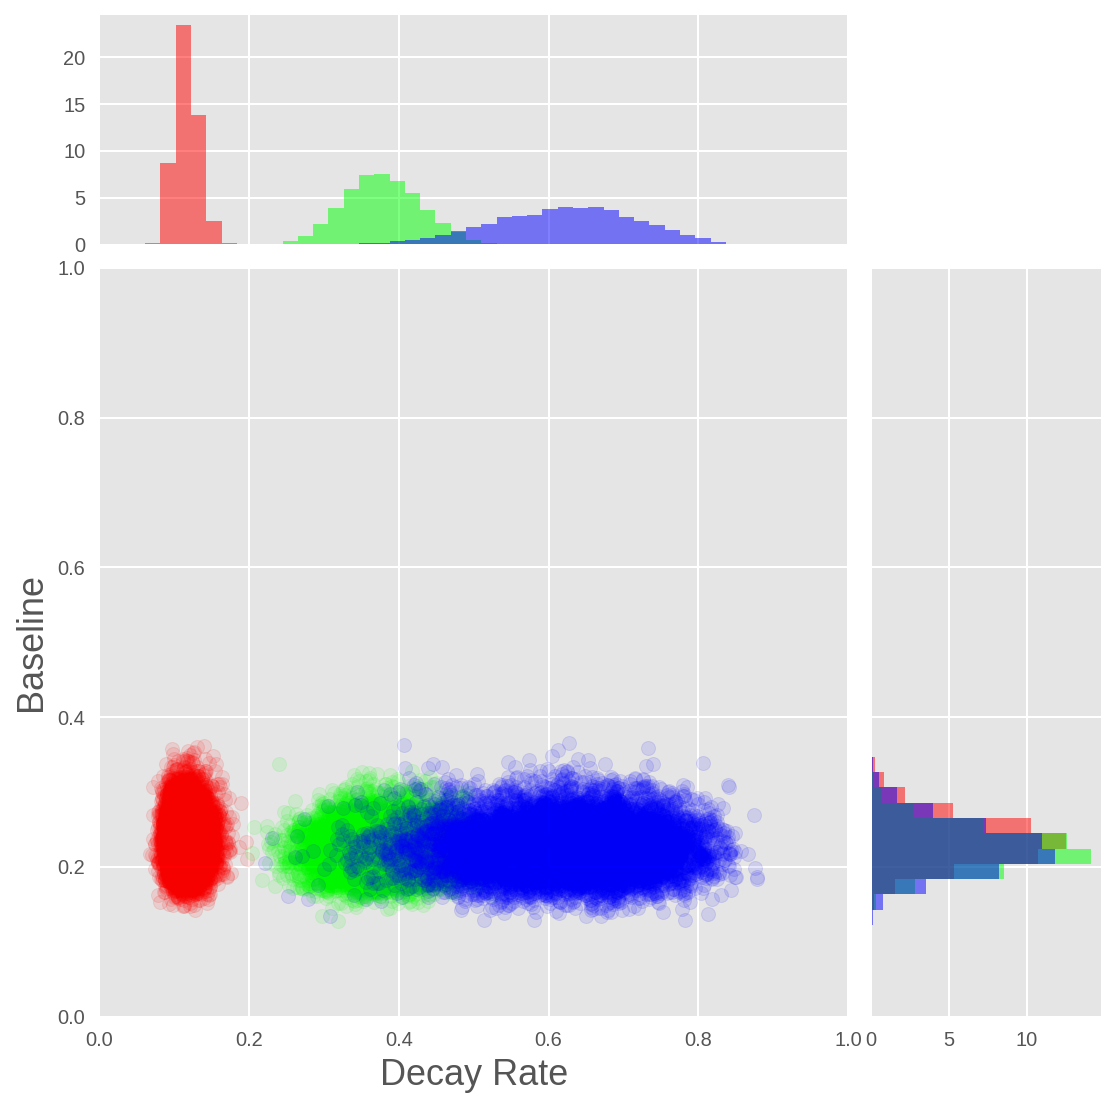

In [23]:
scatter_alpha_beta(trace2_[burnin:])

In [25]:
import theano
tshare = theano.shared(t)
cshare = theano.shared(np.ones(t.shape))

# get starting point from previous trace
with model2_:
    cov = np.atleast_1d(pm.trace_cov(trace2_[burnin:]))
    start = np.random.choice(trace2_[burnin:], 1)
    start = start[0]
    astart = np.append(start['alpha'],.5)
    bstart = np.append(start['beta'],.5)
    start['alpha'] = astart
    start['beta'] = bstart
    start['alpha_logodds_'] = np.append(start['alpha_logodds_'],np.log(.5))
    start['beta_logodds_'] = np.append(start['beta_logodds_'],np.log(.5))
    start['thetaj'] = np.clip(np.exp(-np.outer(astart, t)) +
                              np.outer(bstart, np.zeros(t.shape)),
                              0, 1)
    
with pm.Model() as model2:
    alpha = pm.Beta('alpha', alpha=1, beta=1, shape=ns)
    beta = pm.Beta('beta', alpha=1, beta=1, shape=ns)
    
    theta = tt.exp(-tt.outer(alpha, tshare)) + tt.outer(beta, cshare)
    thetaj = pm.Deterministic('thetaj', tt.clip(theta, 0, 1))
    
    kij = pm.Binomial('kij', p=thetaj, n=n, observed=k1)
    
    step = pm.NUTS(target_accept=.99)
    trace2 = pm.sample(1e4, step=step, start=start)

/usr/local/lib/python3.5/dist-packages/pymc3/sampling.py:166: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
Assigned Metropolis to kij_missing
100%|██████████| 10000/10000.0 [00:16<00:00, 619.95it/s]


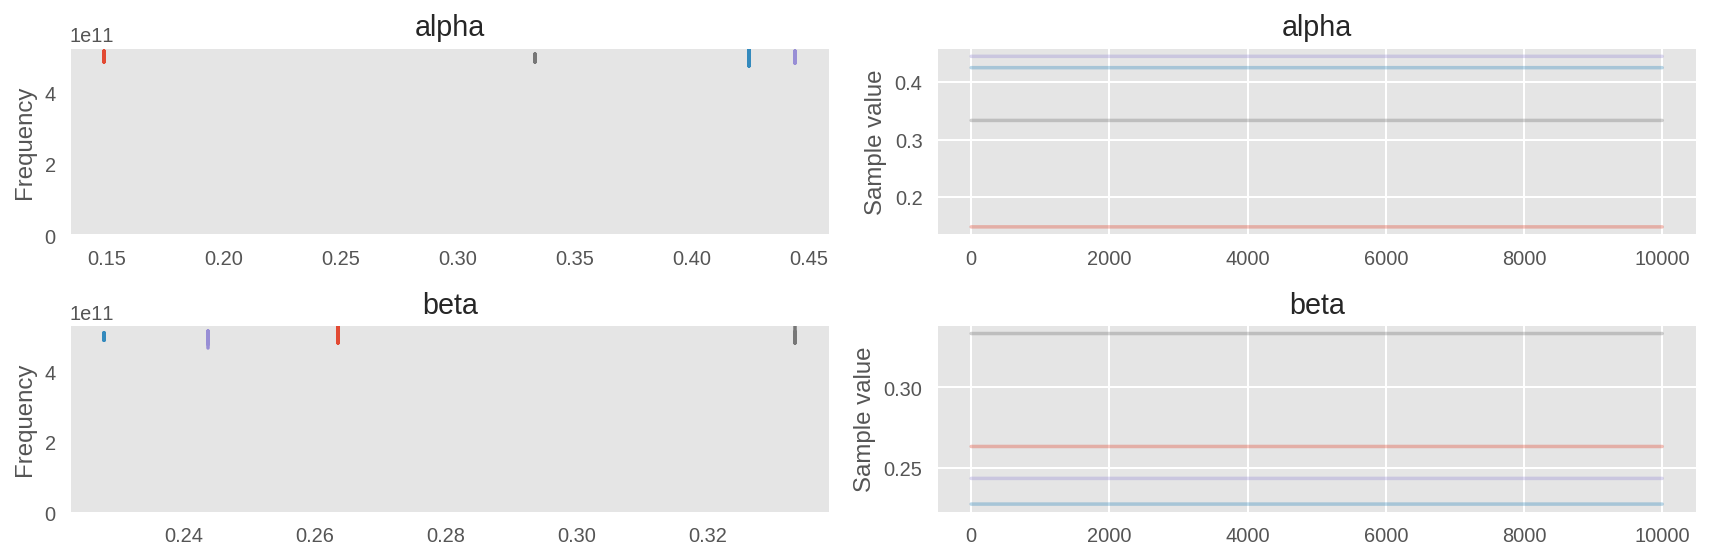

In [27]:
burnin=0
pm.traceplot(trace2[burnin:], varnames=['alpha', 'beta']);
plt.show()

100%|██████████| 500/500 [00:10<00:00, 49.60it/s]


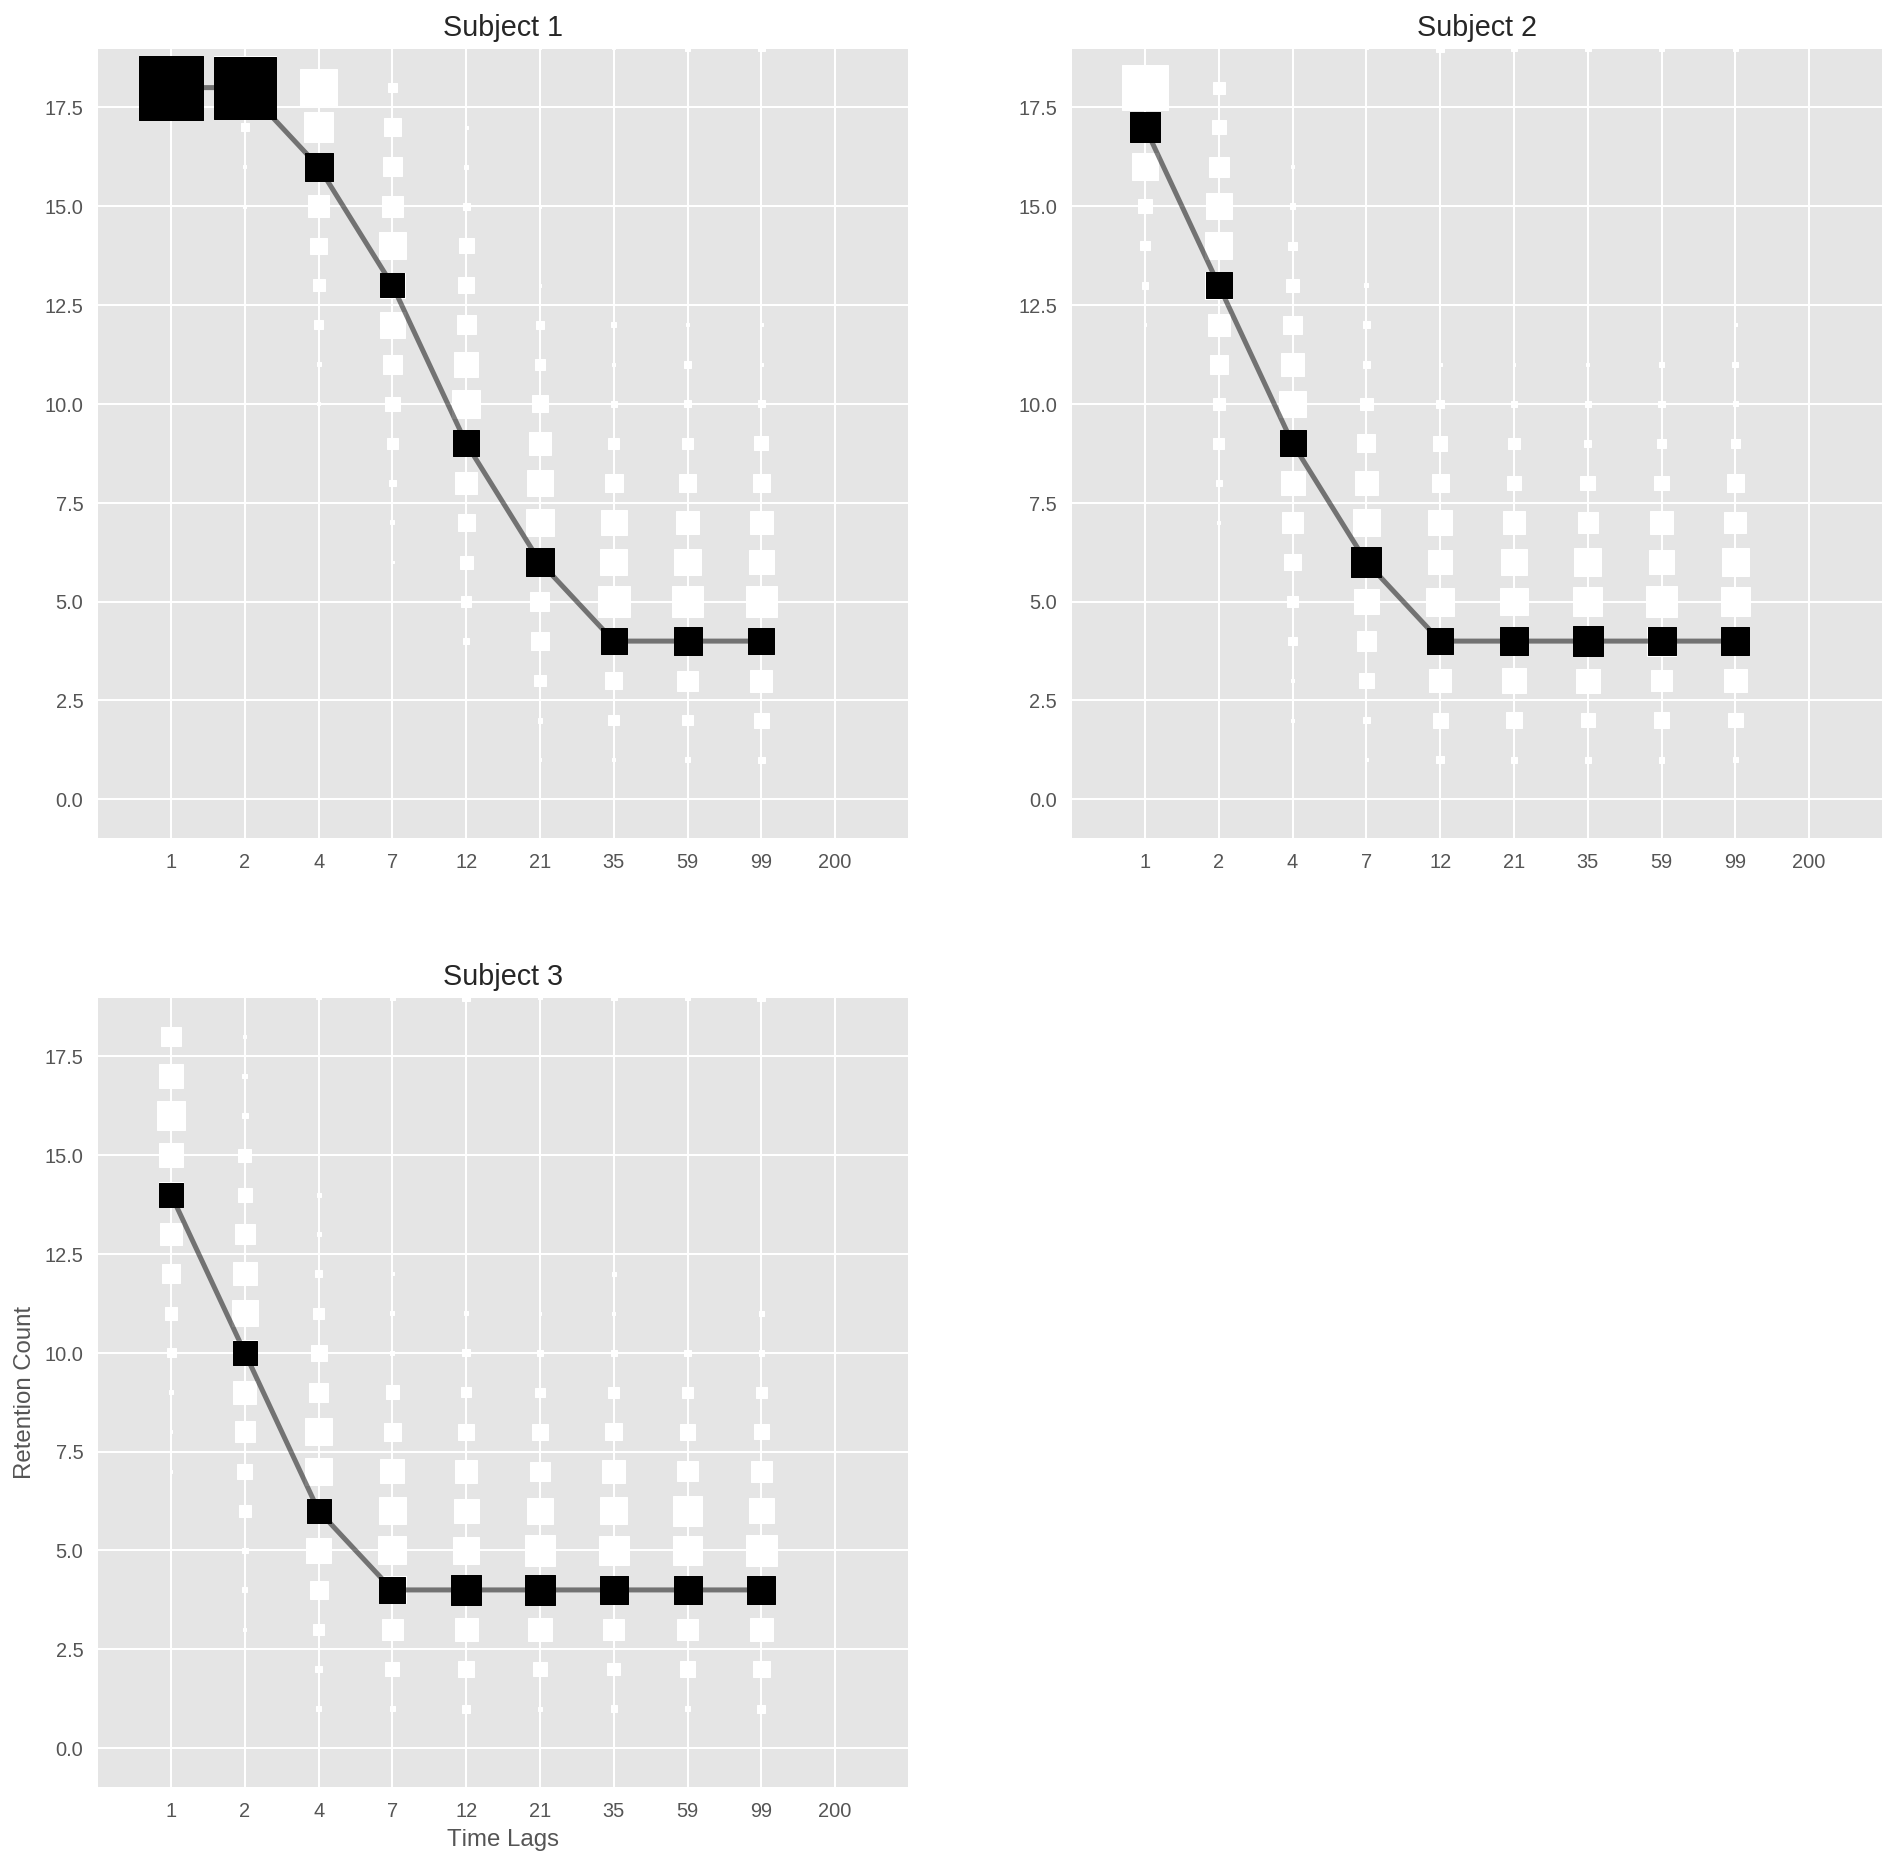

In [28]:
# reproduce Fig 10.3
# The posterior predictive distribution for the model that assumes no individual
# differences.
ppc = pm.sample_ppc(trace2_[burnin:], model=model2_, samples=500)
predictrace = ppc['kij']
plot_predict(predictrace)

## 10.3 Full individual differences


$$ \mu_{\alpha} \sim \text{Beta}(1,1)$$
$$ \lambda_{\alpha} \sim \text{Gamma}(.001,.001)$$
$$ \mu_{\beta} \sim \text{Beta}(1,1)$$
$$ \lambda_{\beta} \sim \text{Gamma}(.001,.001)$$
$$ \alpha_{i} \sim \text{Gaussian}(\mu_{\alpha}, \lambda_{\alpha})_{\mathcal I(0,1)} $$
$$ \beta_{i} \sim \text{Gaussian}(\mu_{\beta}, \lambda_{\beta})_{\mathcal I(0,1)} $$
$$ \theta_{ij} = \text{min}(1,\text{exp}(−\alpha_{i} t_{j})+\beta_{i})$$
$$ k_{ij} \sim \text{Binomial}(\theta_{ij},n)$$

Average Loss = inf: 100%|██████████| 20000/20000 [00:02<00:00, 7182.50it/s]
Finished [100%]: Average Loss = inf
Average Loss = inf: 100%|██████████| 10000/10000 [00:01<00:00, 7199.73it/s]
Finished [100%]: Average Loss = inf


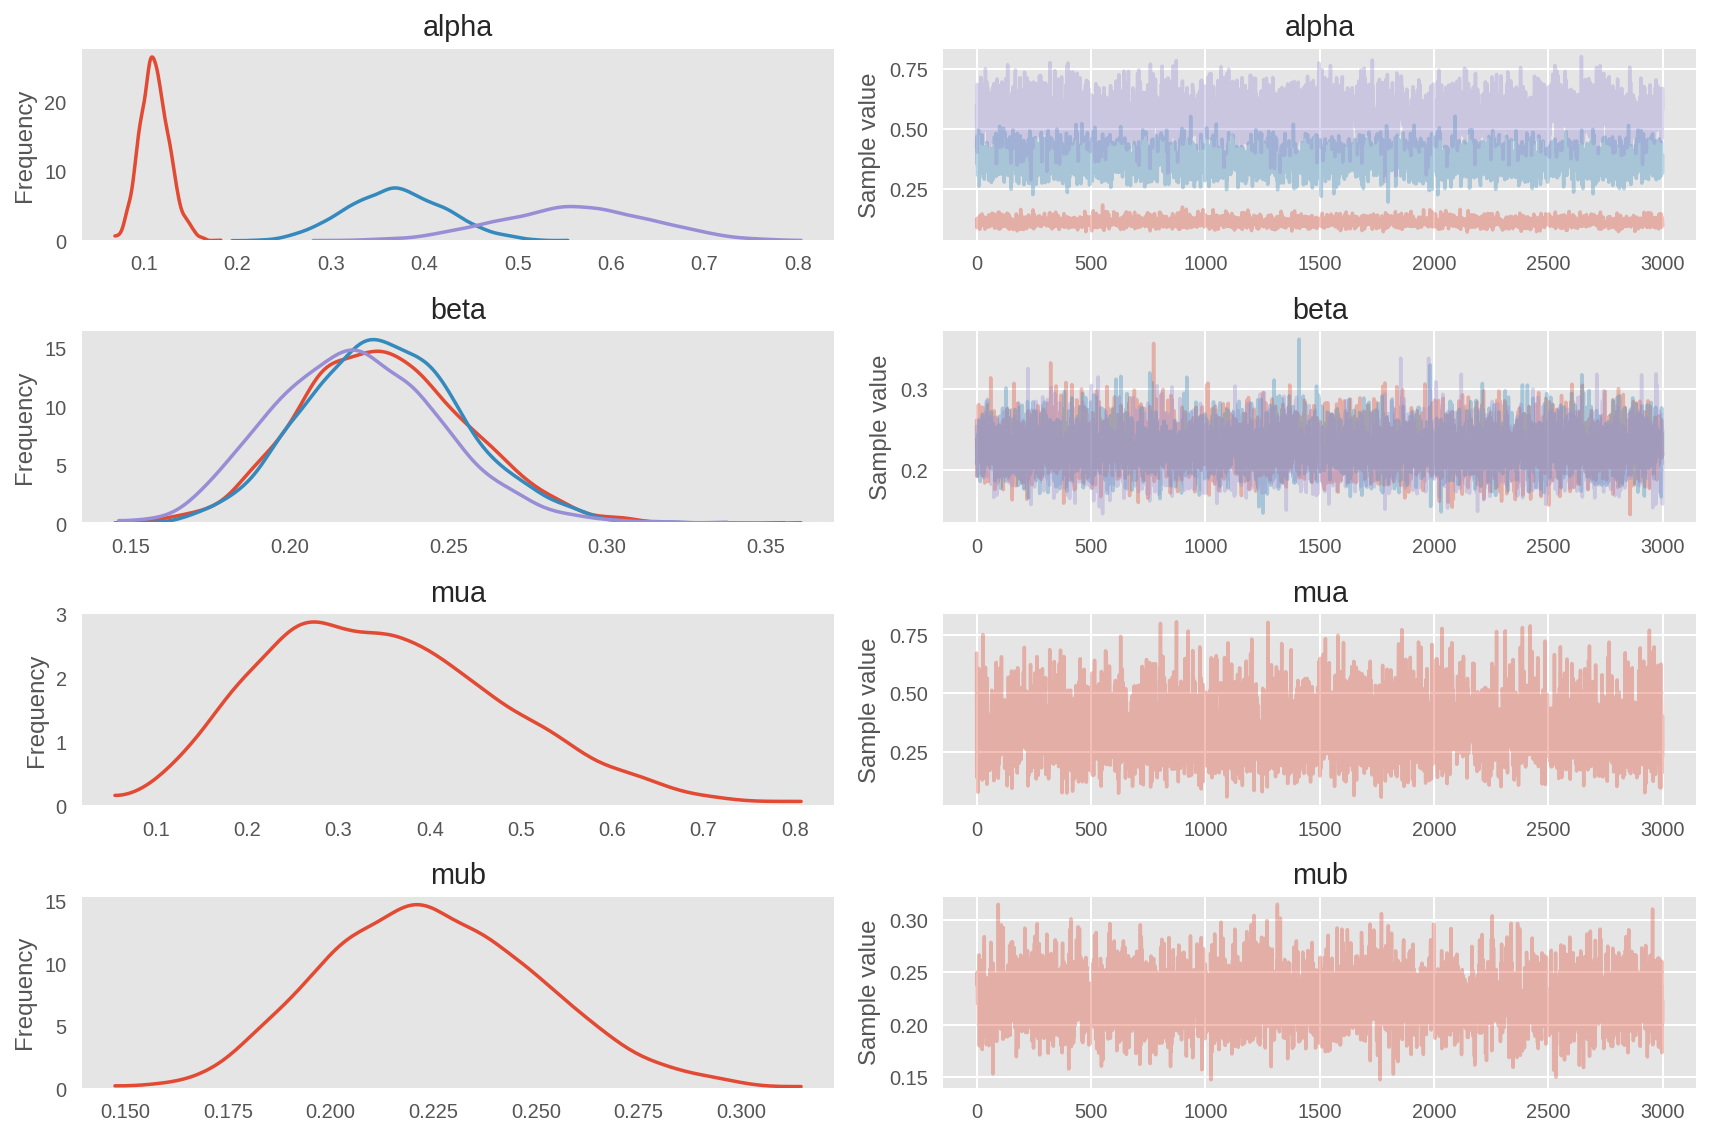

In [10]:
tshare = theano.shared(t2)
cshare = theano.shared(np.ones(t2.shape))

BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1)
with pm.Model() as model3:
    mua = pm.Beta('mua', alpha=1, beta=1)
    lambdaa = pm.Gamma('lambdaa', alpha=.001, beta=.001)
    mub = pm.Beta('mub', alpha=1, beta=1)
    lambdab = pm.Gamma('lambdab', alpha=.001, beta=.001)
    
    alpha = BoundedNormal('alpha', mu=mua, tau=lambdaa, shape=ns2)
    beta = BoundedNormal('beta', mu=mub, tau=lambdab, shape=ns2)
    
    theta = tt.exp(-tt.outer(alpha, tshare)) + tt.outer(beta, cshare)
    thetaj = pm.Deterministic('thetaj', tt.minimum(theta, 1))
    
    kij = pm.Binomial('kij', p=thetaj, n=n, observed=k2)
    
    #step = pm.NUTS(target_accept=.99)
    #trace3_ = pm.sample(1e4, tune=1000, init='ADVI', njobs=2)
    
#     v_params = pm.variational.advi(n=100000)
#     trace3_ = pm.variational.sample_vp(v_params, 3000, progressbar=False,
#                                          hide_transformed=False)

    # New ADVI api
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace3_ = approx.sample_vp(3000) 
    
    elbos1 = -inference.hist
    
burnin=0
pm.traceplot(trace3_[burnin:], varnames=['alpha', 'beta', 'mua', 'mub'])
plt.show()

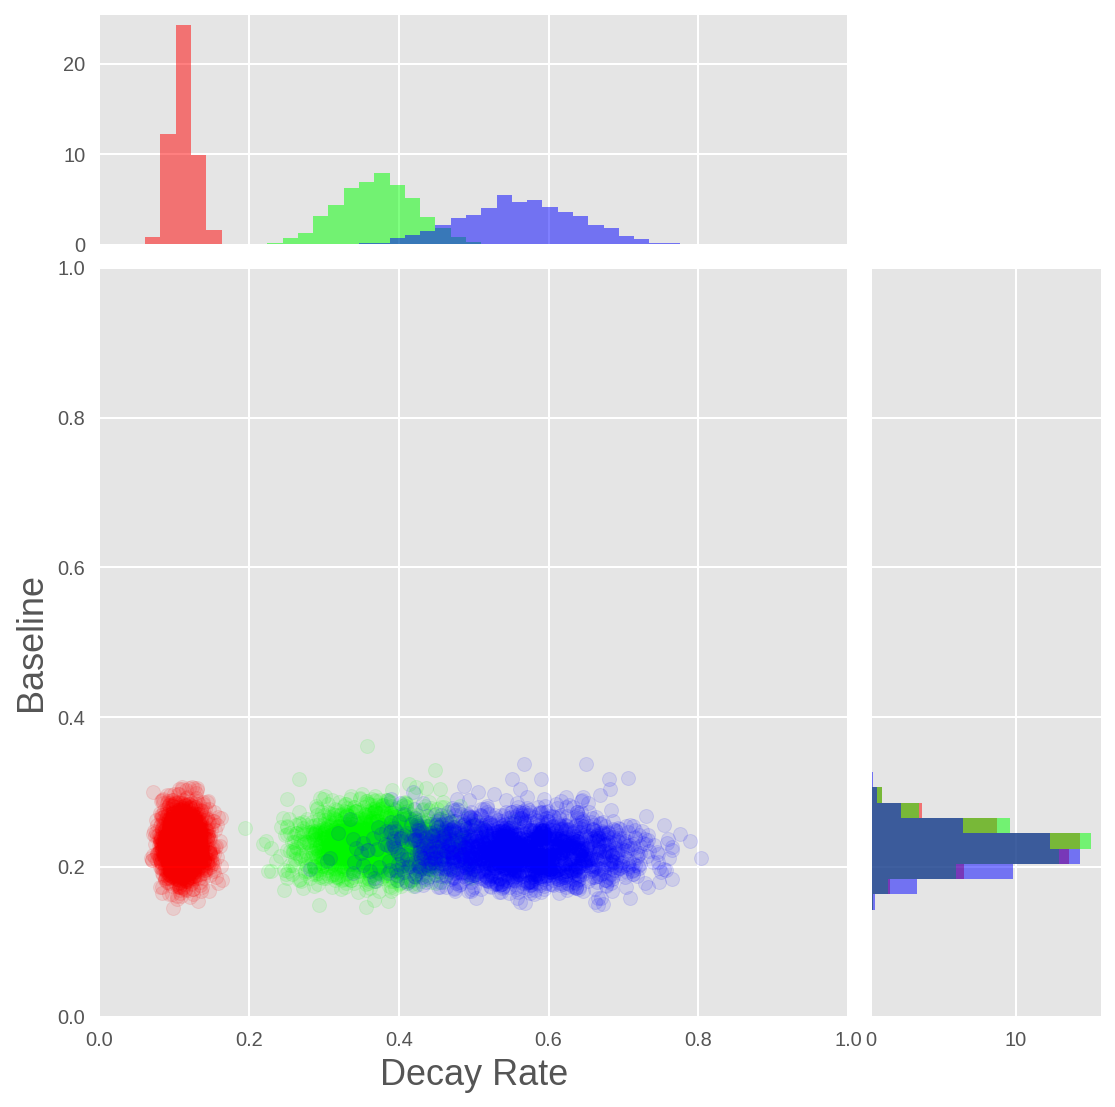

In [11]:
burnin=0
scatter_alpha_beta(trace3_[burnin:])

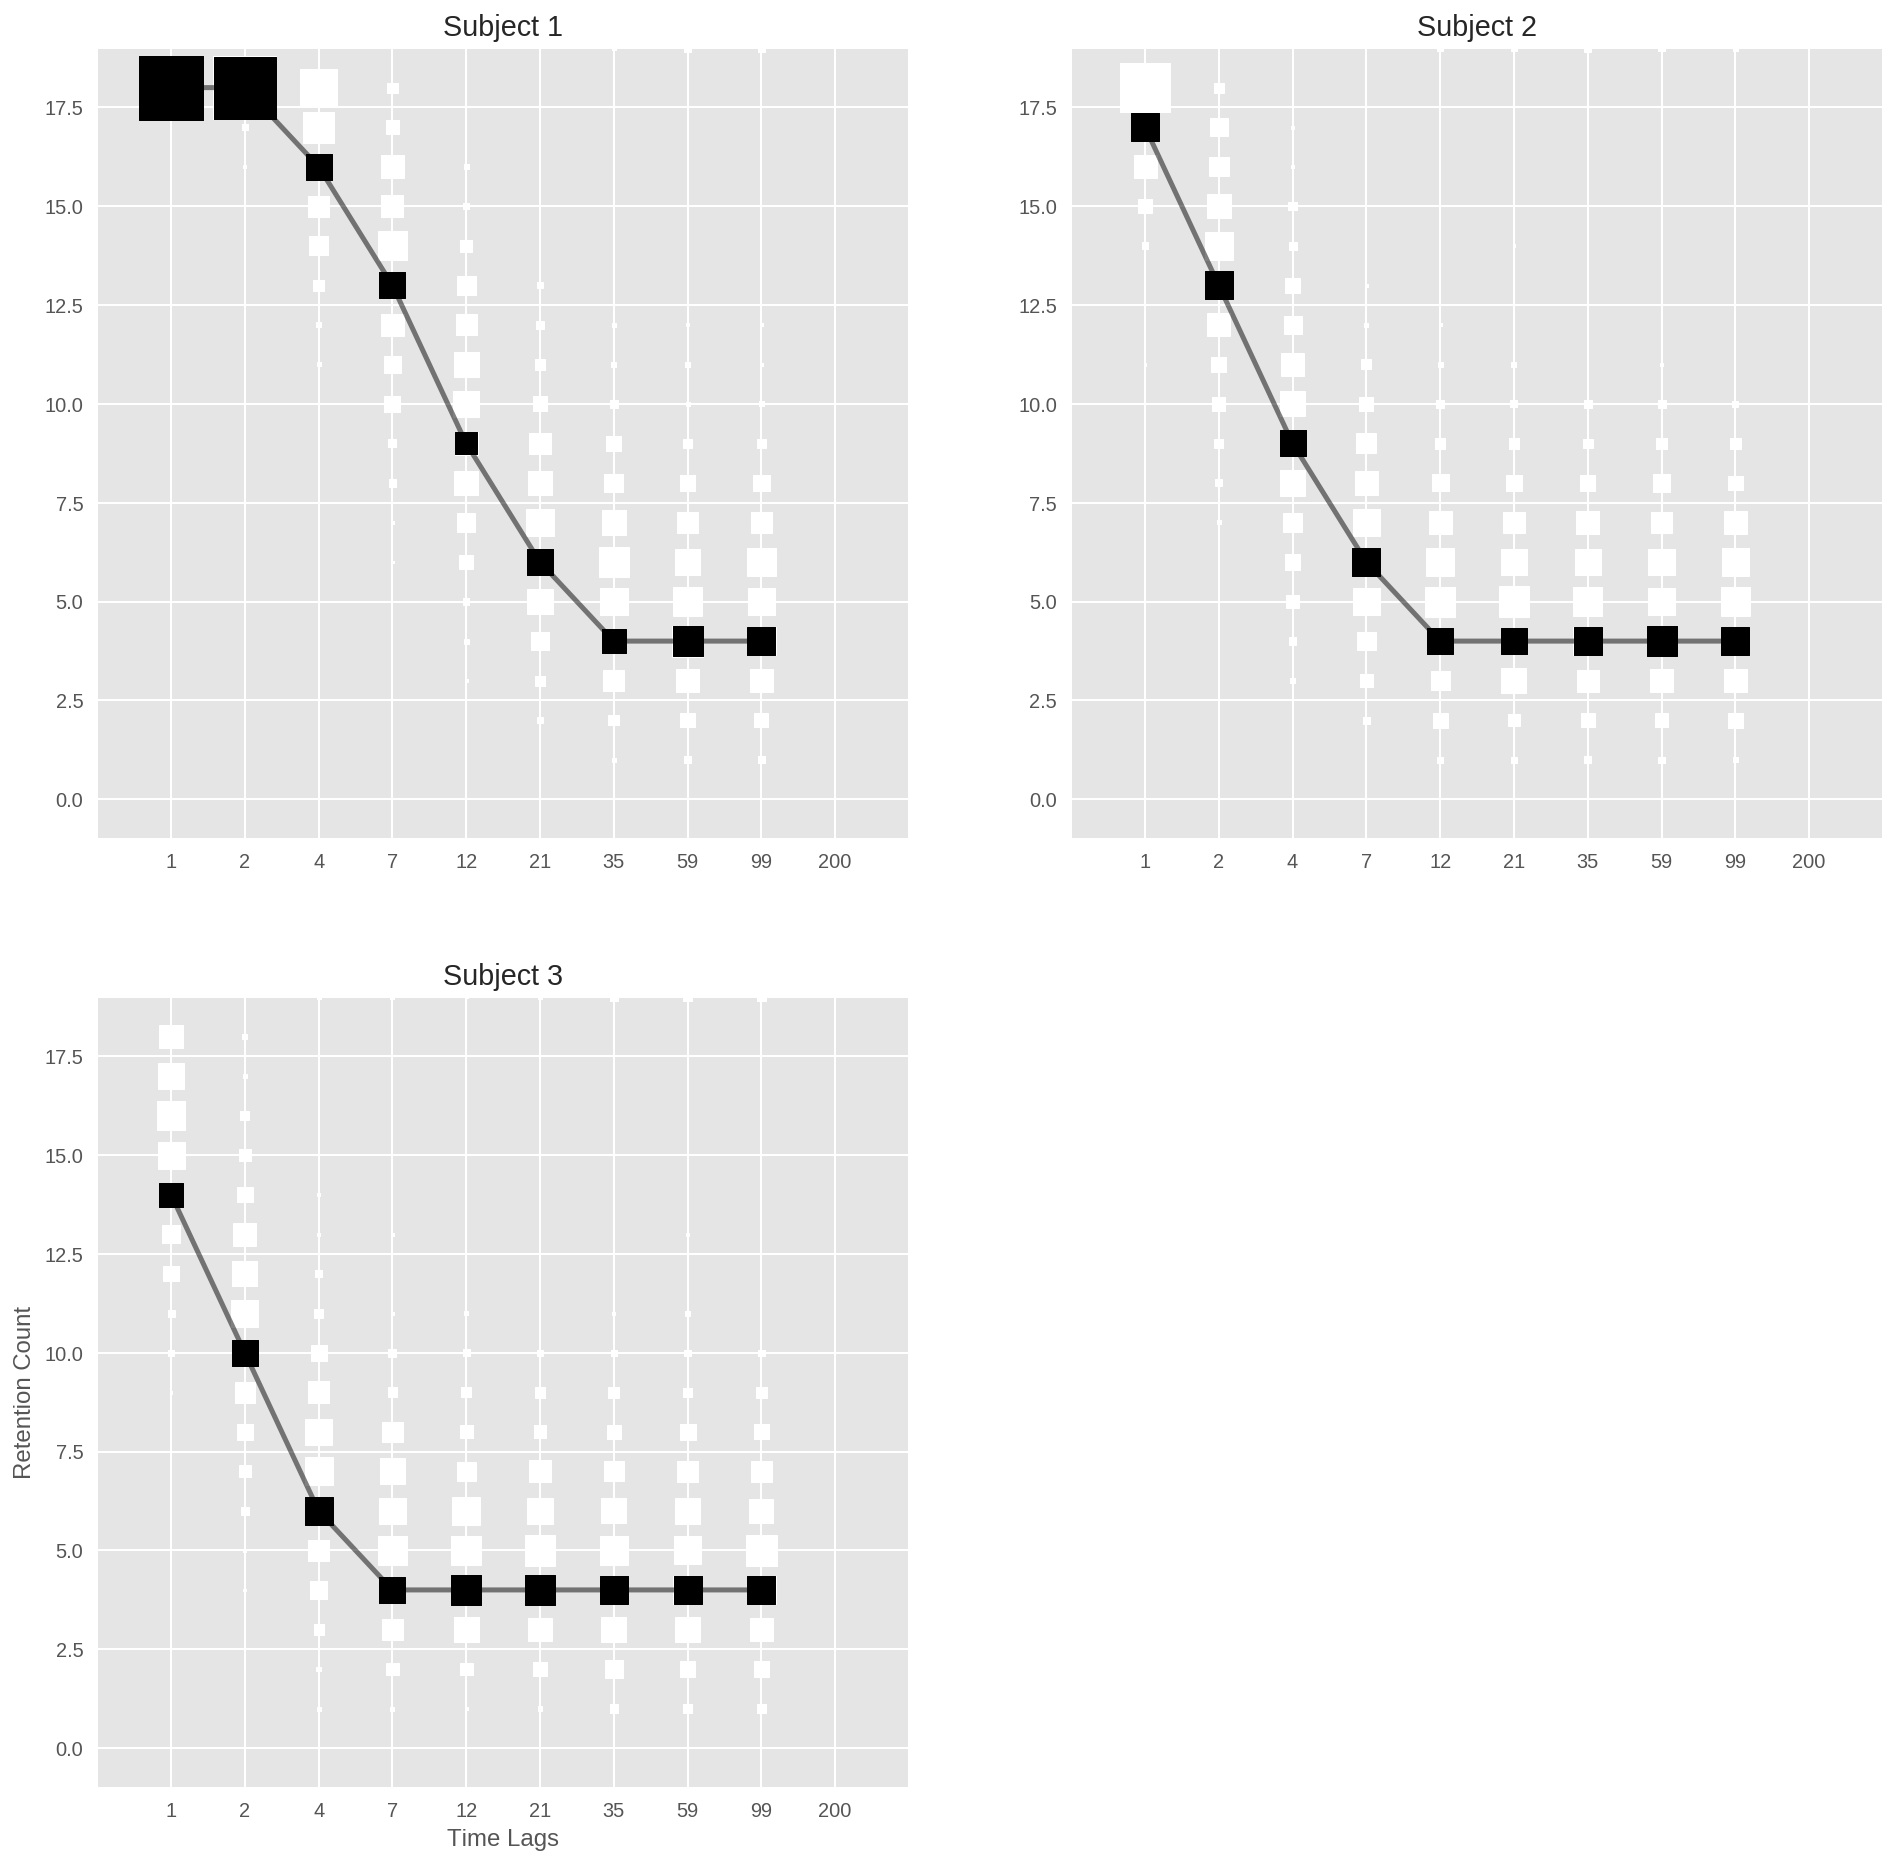

In [21]:
# reproduce Fig 10.9
nsamp_tr = trace3_['thetaj'].shape[0]
index = np.random.choice(nsamp_tr, 500)
ppc = trace3_['thetaj'][index,:,:]
predictrace = np.random.binomial(n,ppc)
plot_predict(predictrace)